In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

## 1 Anomaly detection

In [4]:
def getData(filename):
    data = sio.loadmat(filename)
    return data

In [18]:
def plotData(X):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], color = 'b', marker = '+')
    plt.xlabel("latency(ms)")
    plt.ylabel("throughput(mb/s)")
    plt.title("Figure 1: The ﬁrst dataset.")
    plt.show()

(307, 2) (307, 2) (307,)


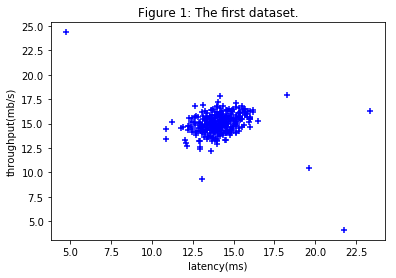

In [156]:
#def main():
data = getData("ex8data1.mat")
X = data['X']
Xval = data['Xval']
yval = data['yval'].ravel()
print(X.shape, Xval.shape, yval.shape)
plotData(X)

### 1.1 Gaussian distribution
The Gaussian distribution is given by
$$p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$
where µ is the mean and $\sigma^2$ controls the variance.

### 1.2 Estimating parameters for a Gaussian 
Note that in Octave/MATLAB, the *variance function* will (by default) use $\frac{1}{m−1}$ , instead of $\frac{1}{m}$, when computing $\sigma^2$.  
But in numpy, the *std function* use $\frac{1}{m}$, when computing $\sigma$.

In [54]:
def estimateGaussian(X):
    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    return mu, sigma

In [53]:
def multivariateGaussian(X, mu, sigma):
    p = np.prod((1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(X-mu)**2/(2*sigma**2)), axis = 1)
    return p

In [118]:
def visualizeFit(X, mu, sigma):
    m = X.shape[0]
    plt.figure(figsize = (6,6))
    plt.scatter(X[:, 0], X[:, 1], color = 'b', marker = '+')
    x = np.arange(0, 30, 0.5)
    y = np.arange(0, 30, 0.5)
    m = x.shape[0]
    xx, yy = np.meshgrid(x, y)
    p = np.zeros((m, m))
    for i in range(m):
        X = np.hstack((xx[:, i:i+1], yy[:, i:i+1]))
        p[:, i] = multivariateGaussian(X, mu, sigma)
    lim = 10.**np.arange(-20, 0, 3)
    plt.contour(xx, yy, p, lim)
    plt.xlabel("latency(ms)")
    plt.ylabel("throughput(mb/s)")
    plt.title("Figure 2: The Gaussian distribution contours of the distribution ﬁt to the dataset.")
    plt.show()

In [38]:
10.**np.arange(-20, 0, 3)  #注：10**np.arange(-20, 0, 3) 会报错(Integers to negative integer powers are not allowed.)

array([1.e-20, 1.e-17, 1.e-14, 1.e-11, 1.e-08, 1.e-05, 1.e-02])

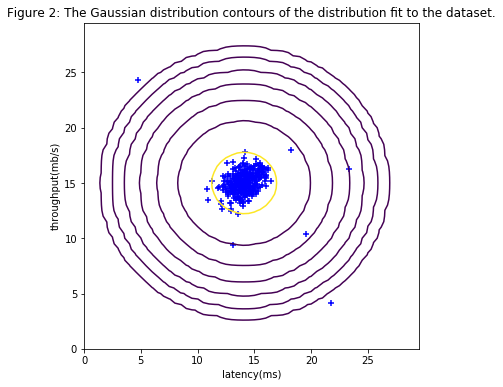

In [119]:
mu, sigma = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma)
visualizeFit(X, mu, sigma)

### 1.3 Selecting the threshold,  $\varepsilon$

In [43]:
def selectThreshold(yval, pval):
    bestF1 = 0
    bestEpsilon = 0
    step = (np.max(pval)-np.min(pval))/1000
    epsilons = np.arange(pval.min()+step, pval.max(), step)
    for epsilon in epsilons:
        cvPredictions = (pval < epsilon)
        tp = np.sum(cvPredictions[np.where(yval == 1)] == 1)
        fp = np.sum(cvPredictions[np.where(yval == 0)] == 1)
        fn = np.sum(cvPredictions[np.where(yval == 1)] == 0)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        F1 = 2*precision*recall/(precision + recall)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

8.990852779269492e-05 0.8750000000000001


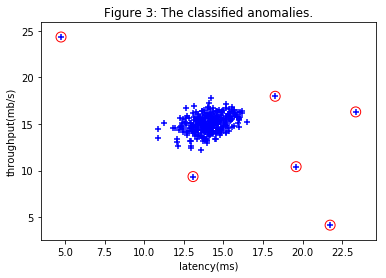

In [192]:
pval = multivariateGaussian(Xval, mu, sigma)
epsilon, F1 = selectThreshold(yval, pval)
print(epsilon, F1)
outliers = np.where(p < epsilon)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], color = 'b', marker = '+')
plt.scatter(X[outliers, 0], X[outliers, 1],  marker = 'o', s = 100, color = '', edgecolor = 'r')
plt.xlabel("latency(ms)")
plt.ylabel("throughput(mb/s)")
plt.title("Figure 3: The classified anomalies.")
plt.show()

### 1.4 High dimensional dataset
- **Anomaly	detection using the multivariate Gaussian distribution**

**Multivariate Gaussian(Normal) distribution:**  
Parameters $\mu$, $\Sigma$ :
$$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^\frac{n}{2}|\Sigma|^\frac{1}{2}}exp\Big( -\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu) \Big)$$

$$\mu = \frac1{m}\sum_{i=1}^mx^{(i)} \quad,\quad\quad \Sigma = \frac1m\sum_{i=1}^m(x^{(i)}-\mu)(x^{(i)}-\mu)^T$$

(x: n dimentional vector, then $\Sigma$: n * n matrix. **Must	have m>n, or else $\Sigma$ is non-invertible**)

In [16]:
def estimateGaussian2(X):
    m = X.shape[0]
    mu = np.mean(X, axis = 0)
    Sigma2 = (1/m) * np.dot((X - mu).T, (X - mu))
    return mu, Sigma2

In [13]:
def multivariateGaussian2(X, mu, Sigma2):
    m, n = X.shape
    p = np.zeros(m)
    for i in range(m):
        p[i] = (2*np.pi)**(-n/2) * np.linalg.det(Sigma2)**(-0.5) * \
            np.exp(-0.5*np.dot((X[i,:]-mu),np.dot(np.linalg.inv(Sigma2), (X[i,:]-mu).T)))
    return p

In [60]:
data = sio.loadmat("ex8data2.mat")
X = data['X']
Xval, yval = data['Xval'], data['yval'].ravel()
print(X.shape, Xval.shape, yval.shape)
mu, Sigma2 = estimateGaussian2(X)
print(mu.shape, Sigma2.shape)
p = multivariateGaussian2(X, mu, Sigma2)
print(p.shape)
pval = multivariateGaussian2(Xval, mu, Sigma2)
epsilon, F1 = selectThreshold(yval, pval)
print(epsilon, F1)
print("Outliers found:", np.sum(p < epsilon))

(1000, 11) (100, 11) (100,)
(11,) (11, 11)
(1000,)
1.7538488712458796e-18 0.5517241379310345
Outliers found: 122
